In [1]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt

from helper_functions import *
from data_functions import *
from models import *

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('train_data.csv')
display(data)

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0


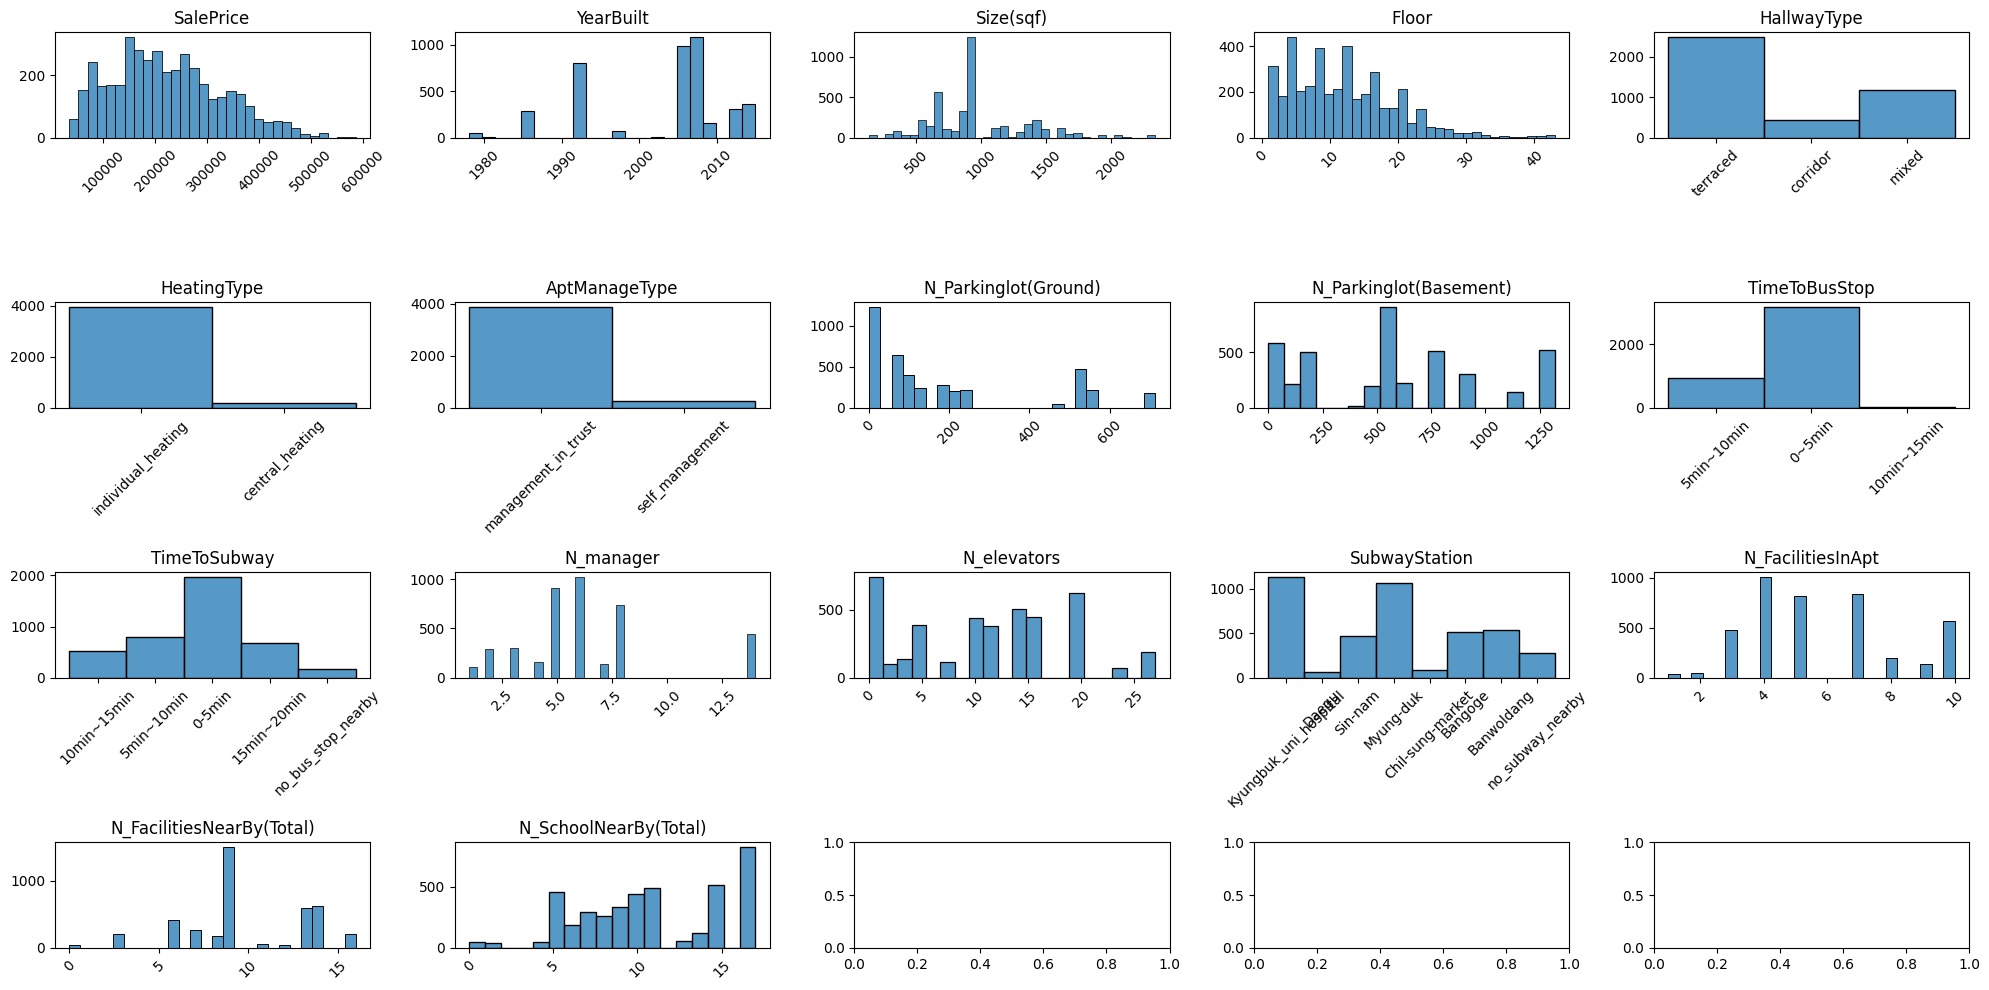

In [5]:
fig, ax = plt.subplots(4, 5, figsize=(20, 10))
for i in range(4):
    for j in range(5):
        if i*5+j > 16:
            break
        sns.histplot(data.iloc[:, i*5+j], ax=ax[i, j])
        ax[i, j].set_title(data.columns[i*5+j])
        ax[i, j].set_xlabel('')
        ax[i, j].set_ylabel('')
        for tick in ax[i, j].get_xticklabels():
            tick.set_rotation(45)
plt.tight_layout()
plt.show()

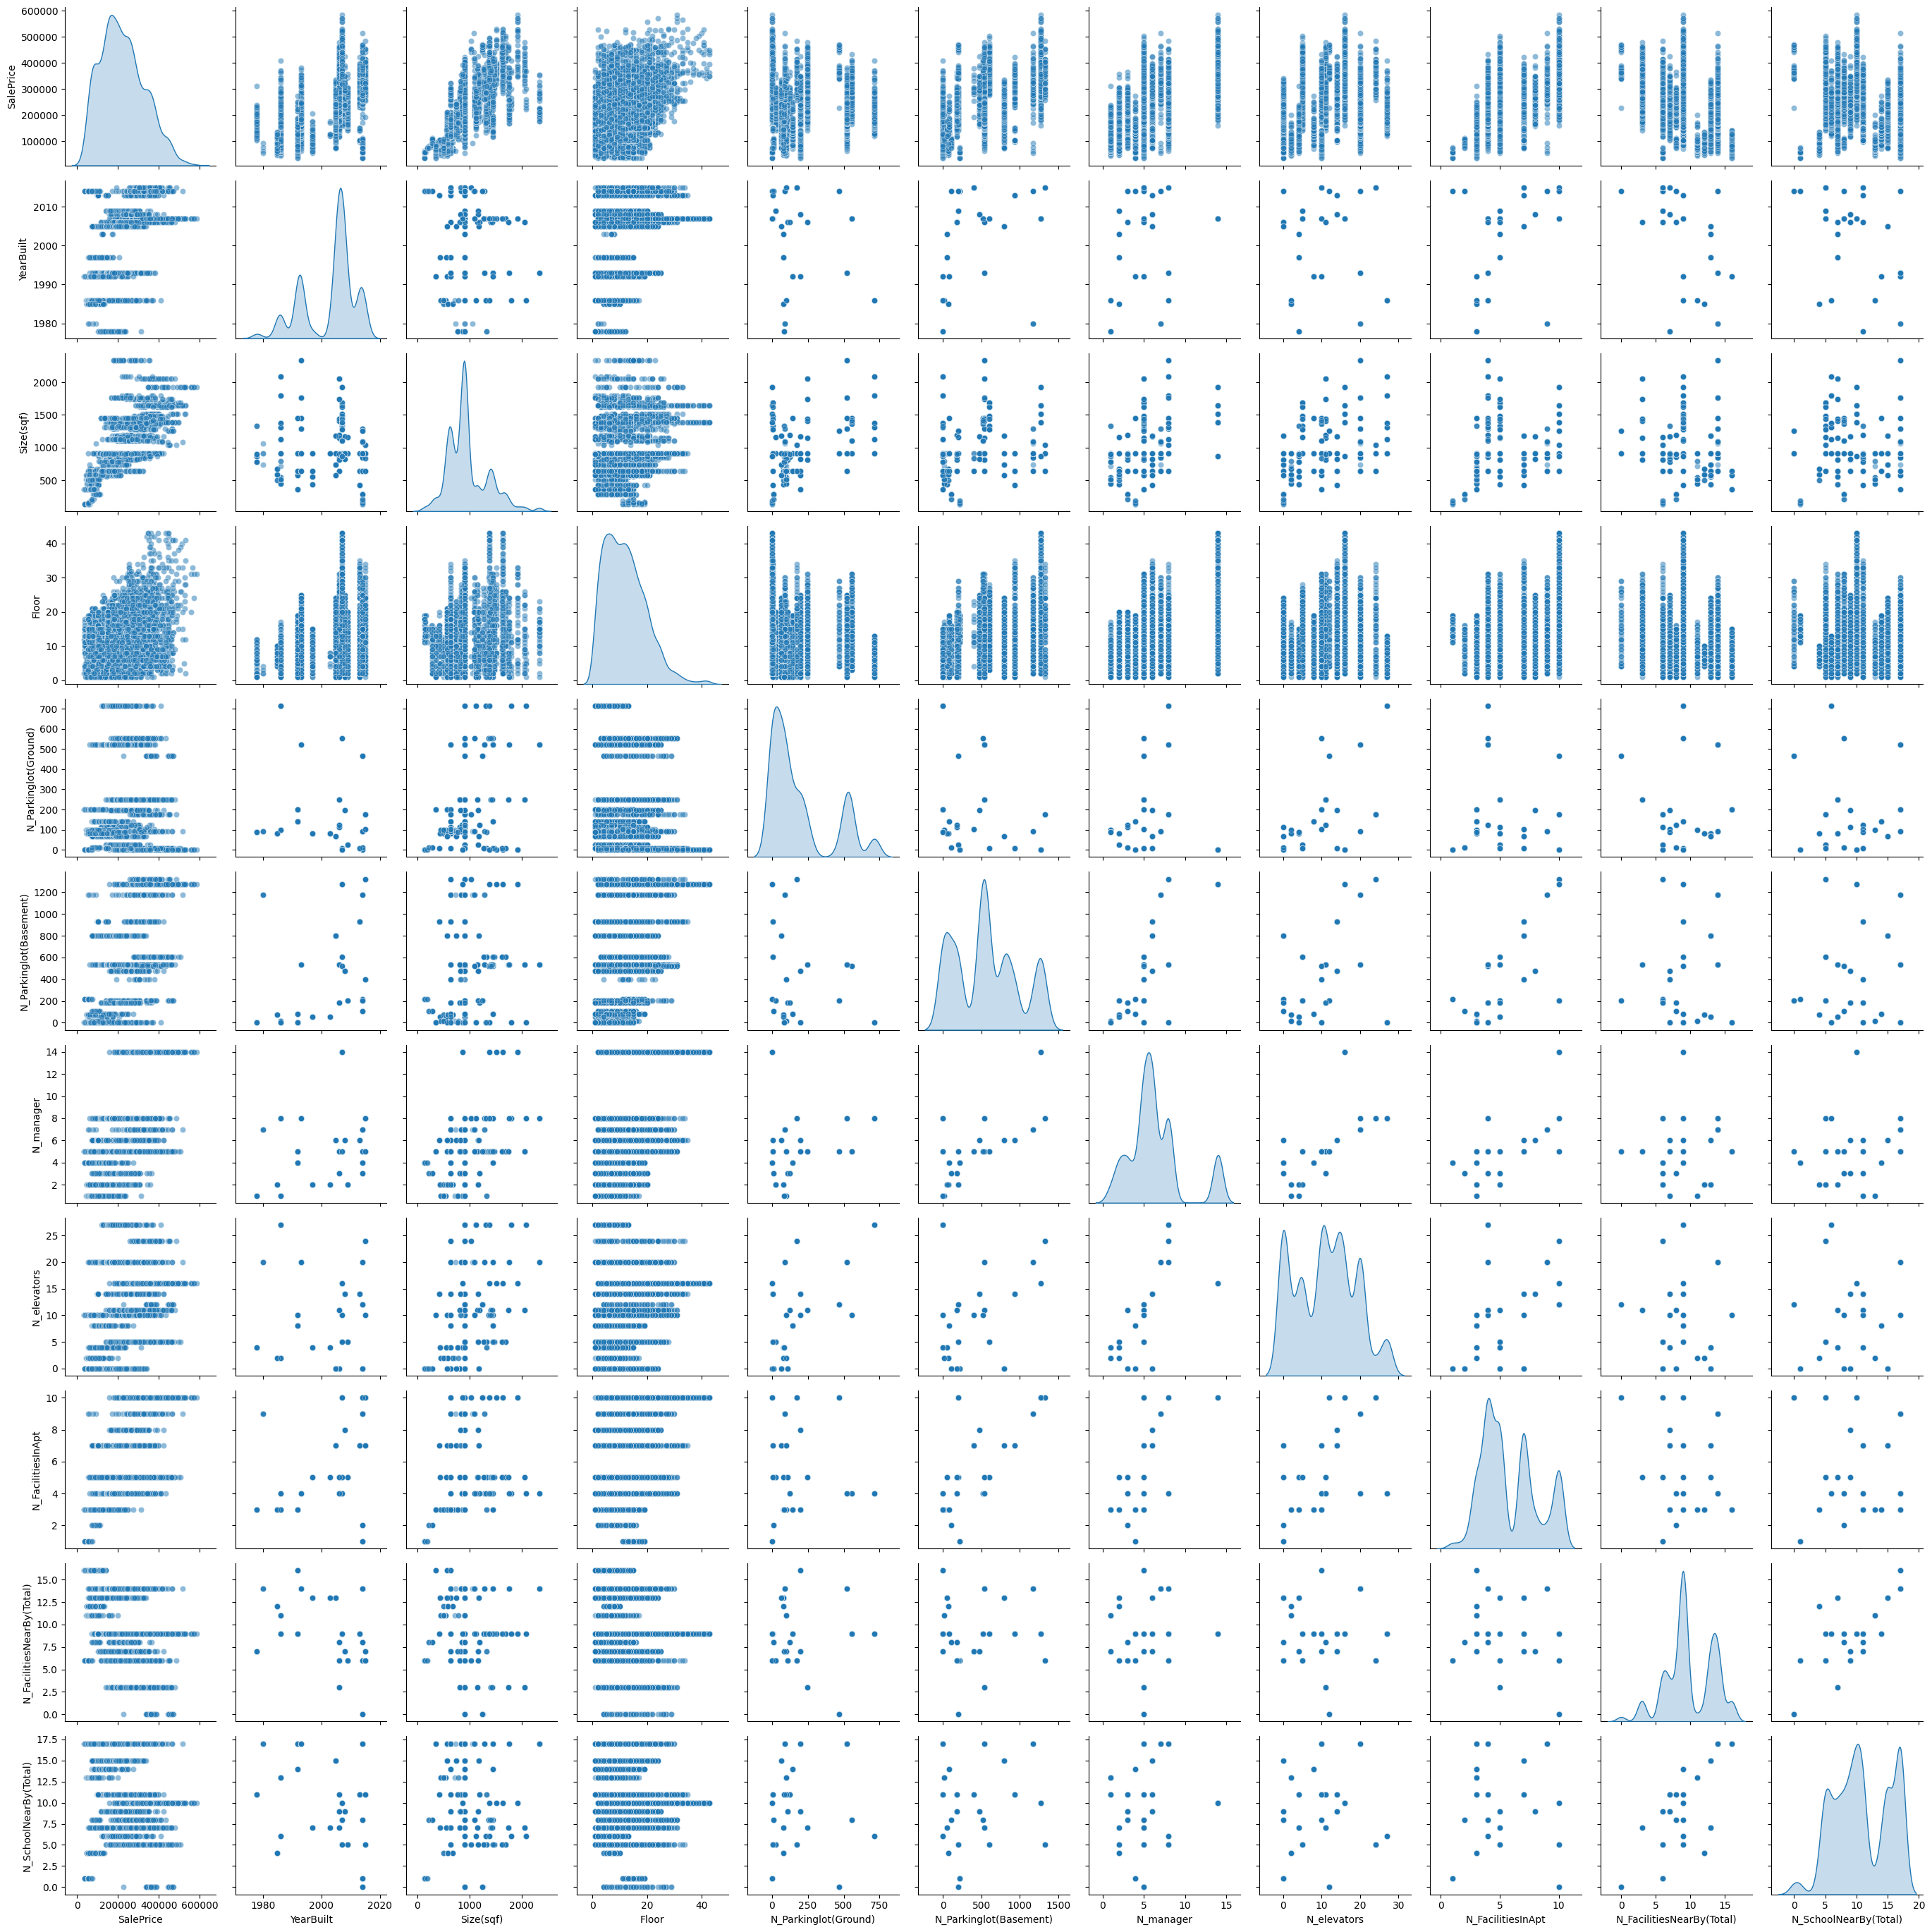

In [8]:
sns.pairplot(data, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.tight_layout()
plt.show()

# Bazowe podejście

## Przetwarzanie danych

In [4]:
data = output_to_labels(data, "SalePrice")
display(data)

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),SalePrice
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,1
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,2
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0,2
4120,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0,1
4121,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0,2
4122,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0,1


In [5]:
categories = data.select_dtypes(include="object").columns
print(categories)
data_proc = get_dummies(data, categories)

display(data_proc)

Index(['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop',
       'TimeToSubway', 'SubwayStation'],
      dtype='object')


,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,2006,814,3,111.0,184.0,3.0,0.0,5,6.0,9.0,...,False,False,False,False,False,False,True,False,False,False
1,1985,587,8,80.0,76.0,2.0,2.0,3,12.0,4.0,...,True,False,False,False,False,True,False,False,False,False
2,1985,587,6,80.0,76.0,2.0,2.0,3,12.0,4.0,...,True,False,False,False,False,True,False,False,False,False
3,2006,2056,8,249.0,536.0,5.0,11.0,5,3.0,7.0,...,False,False,False,False,False,False,False,False,True,False
4,1992,644,2,142.0,79.0,4.0,8.0,3,9.0,14.0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,2007,1928,24,0.0,1270.0,14.0,16.0,10,9.0,10.0,...,False,False,False,False,False,False,True,False,False,False
4120,2015,644,22,102.0,400.0,5.0,10.0,7,7.0,11.0,...,True,False,False,False,False,True,False,False,False,False
4121,2007,868,20,0.0,1270.0,14.0,16.0,10,9.0,10.0,...,False,False,False,False,False,False,True,False,False,False
4122,1978,1327,1,87.0,0.0,1.0,4.0,3,7.0,11.0,...,False,False,False,False,False,False,True,False,False,False


In [6]:
data_proc = remove_corr_features(data_proc, "SalePrice", 0.8)
display(data_proc)

,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesNearBy(Total),SalePrice,HallwayType_corridor,...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,2006,814,3,111.0,184.0,3.0,0.0,6.0,1,False,...,False,False,False,False,False,False,True,False,False,False
1,1985,587,8,80.0,76.0,2.0,2.0,12.0,0,True,...,True,False,False,False,False,True,False,False,False,False
2,1985,587,6,80.0,76.0,2.0,2.0,12.0,0,True,...,True,False,False,False,False,True,False,False,False,False
3,2006,2056,8,249.0,536.0,5.0,11.0,3.0,2,False,...,False,False,False,False,False,False,False,False,True,False
4,1992,644,2,142.0,79.0,4.0,8.0,9.0,0,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,2007,1928,24,0.0,1270.0,14.0,16.0,9.0,2,False,...,False,False,False,False,False,False,True,False,False,False
4120,2015,644,22,102.0,400.0,5.0,10.0,7.0,1,False,...,True,False,False,False,False,True,False,False,False,False
4121,2007,868,20,0.0,1270.0,14.0,16.0,9.0,2,False,...,False,False,False,False,False,False,True,False,False,False
4122,1978,1327,1,87.0,0.0,1.0,4.0,7.0,1,True,...,False,False,False,False,False,False,True,False,False,False


In [7]:
train, valid = train_valid_split(data_proc)
train = data_to_dataset(train, target="SalePrice")
valid = data_to_dataset(valid, target="SalePrice")
display(train.tensors[0].shape, valid.tensors[0].shape)

torch.Size([3299, 28])

torch.Size([825, 28])

## Trenowanie modelu

In [8]:
net = Net(train.tensors[0].shape[1], 100, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
train_m = False 
if train_m:
    iters_list, loss_list, train_eval_list, valid_eval_list = train_model(net, train, valid, criterion, optimizer, get_accuracy)
else:
    state_dict = torch.load("starting_model.tar")
    net.load_state_dict(state_dict)

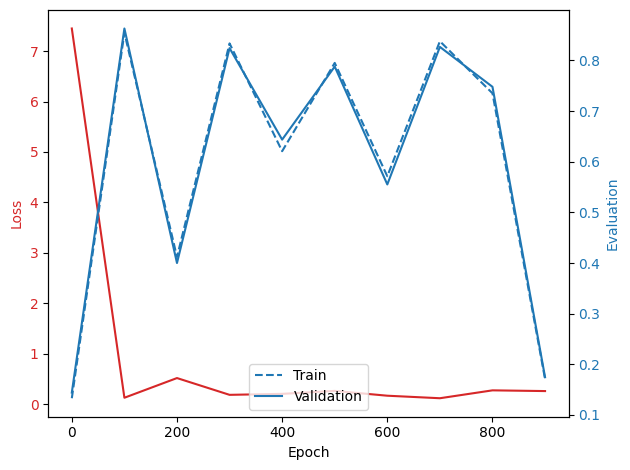

In [12]:
plot_training(iters_list, loss_list, train_eval_list, valid_eval_list)

## Ewaluacja modelu

In [10]:
final_acc = get_accuracy(net, valid)
final_mse = get_mse(net, valid)
print(final_acc)
print(final_mse)

0.8569696969696969
0.4630824327468872


In [11]:
data_expensive = data_proc.loc[data_proc["SalePrice"] == 2]
_, valid_expensive = train_valid_split(data_expensive)
valid_expensive = data_to_dataset(data_expensive, target="SalePrice")

final_acc_expensive = get_accuracy(net, valid_expensive)
final_mse_expensive = get_mse(net, valid_expensive)
print("Model accuracy on expensive houses:")
print(final_acc_expensive)
print("Model MSE on expensive houses:")
print(final_mse_expensive)

Model accuracy on expensive houses:
0.5456140350877193
Model MSE on expensive houses:
0.3215921223163605


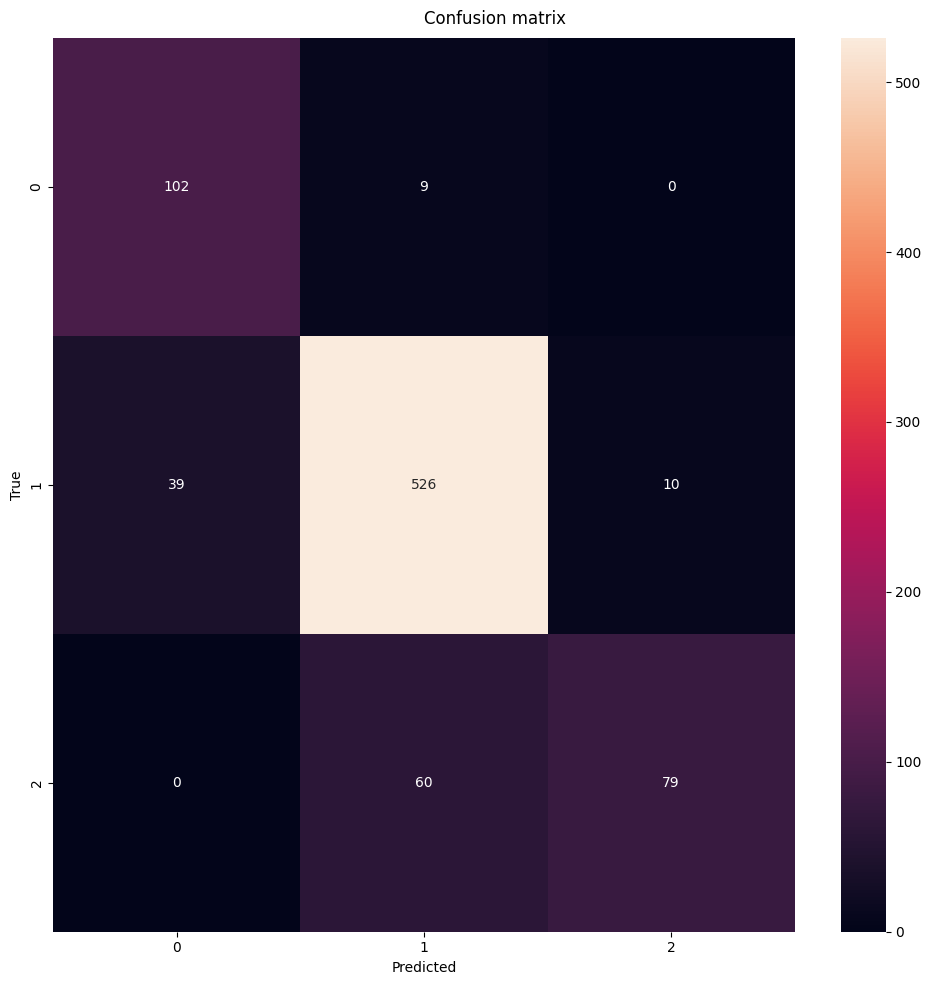

In [12]:
get_confusion_matrix(net, valid)

In [14]:
torch.save(net.state_dict(), "starting_model.tar")

- Model słabo sobie radzi z ostatnią klasą
- Trzeba bardziej rozbudować model

# Normalizacja danych 

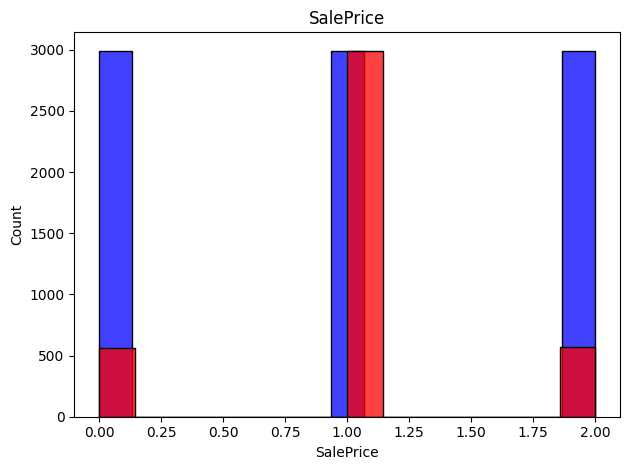

In [8]:
from data_functions import equalize_classes

data_eq = equalize_classes(data_proc, "SalePrice")

fig, ax = plt.subplots()
sns.histplot(data_eq["SalePrice"], ax=ax, label="equalized", color="blue")
sns.histplot(data["SalePrice"], ax=ax, color="red", label="original")
ax.set_title("SalePrice")
plt.tight_layout()
plt.show()

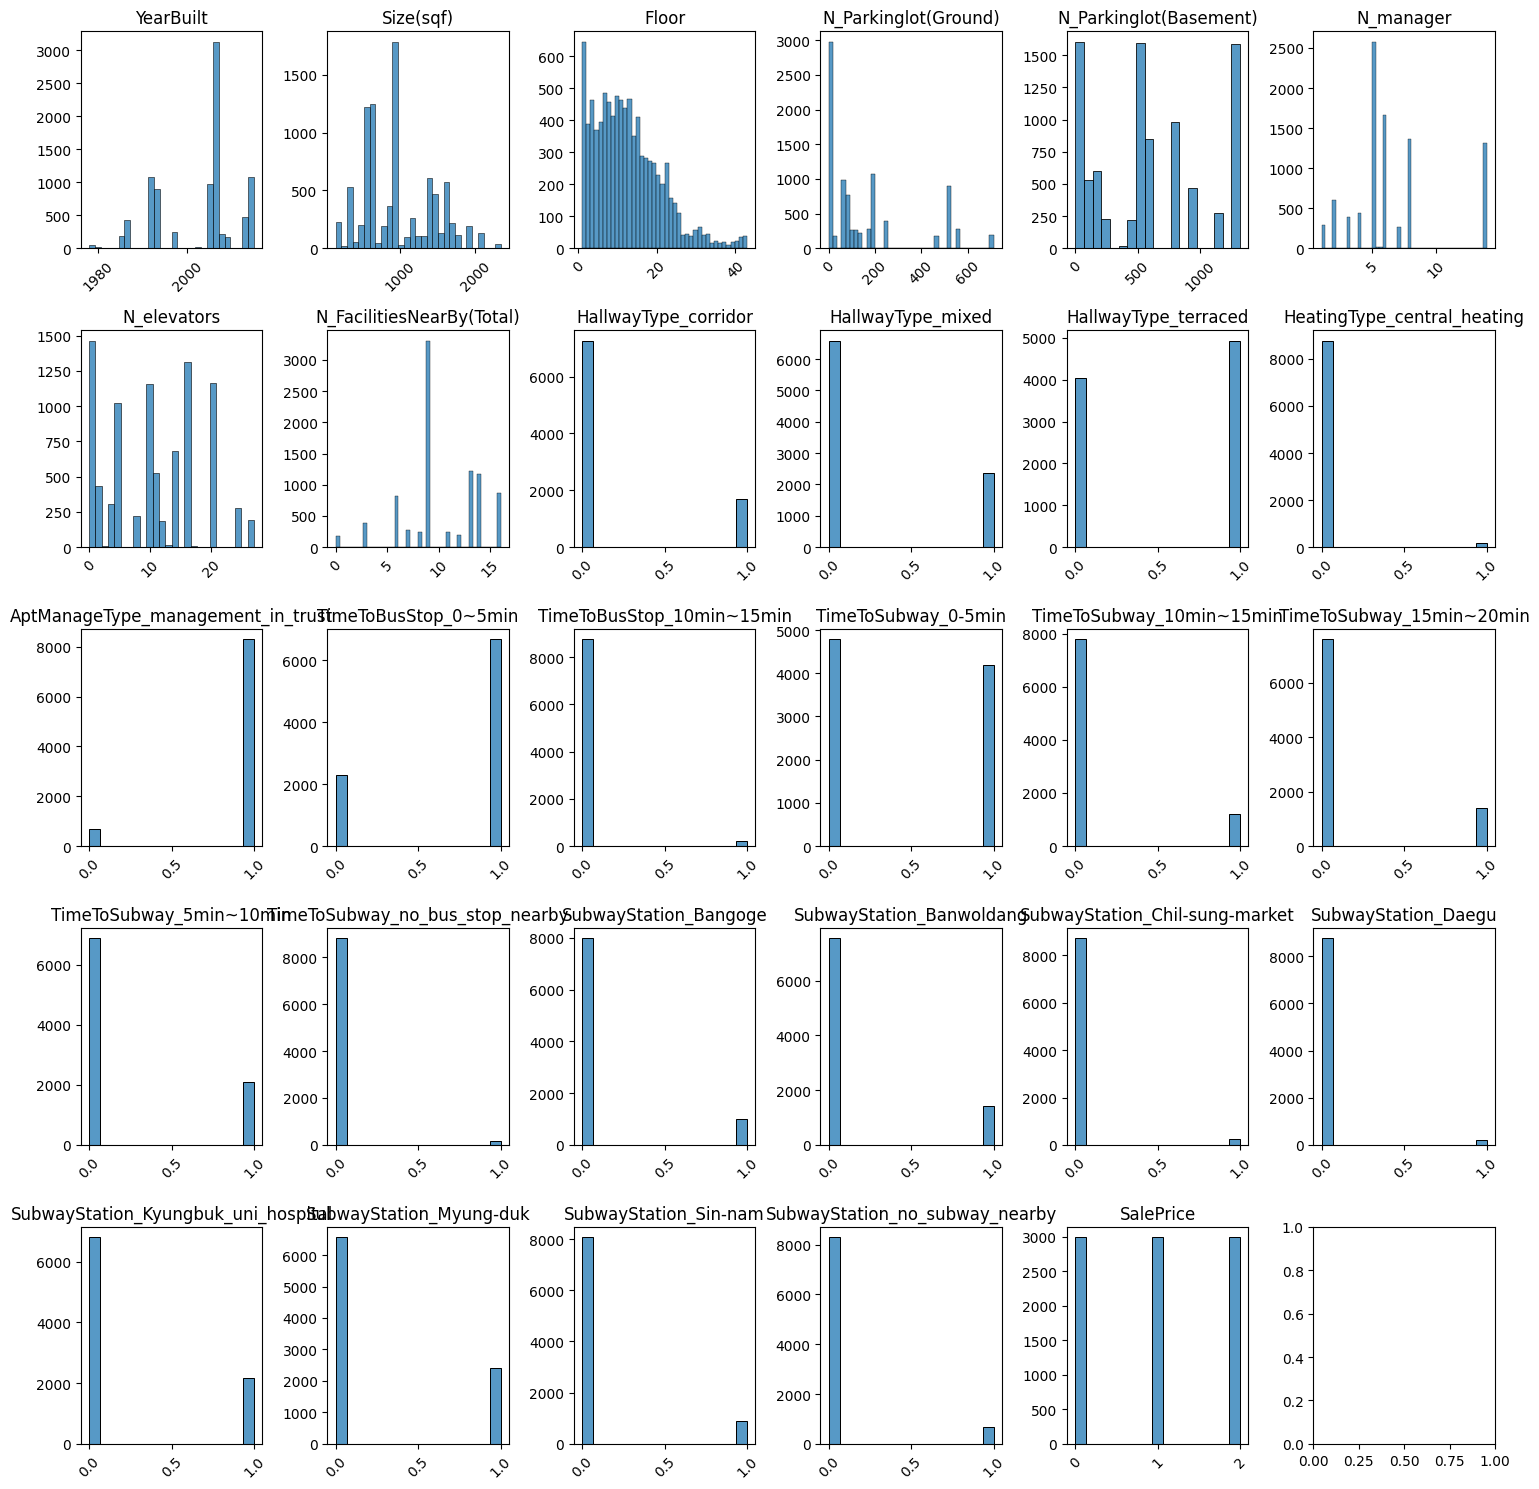

In [18]:
fig, ax = plt.subplots(5, 6, figsize=(15, 15))
for i in range(6):
    for j in range(6):
        if i*6+j > 28:
            break
        sns.histplot(data_eq.iloc[:, i*6+j], ax=ax[i, j])
        ax[i, j].set_title(data_eq.columns[i*6+j])
        ax[i, j].set_xlabel('')
        ax[i, j].set_ylabel('')
        for tick in ax[i, j].get_xticklabels():
            tick.set_rotation(45)
plt.tight_layout()
plt.show()

In [9]:
from data_functions import train_valid_split, data_to_dataset
from helper_functions import train_model, get_mse, get_accuracy
from models import Net

In [10]:
train_eq, valid_eq = train_valid_split(data_eq)

train_eq = data_to_dataset(train_eq, target="SalePrice")
valid_eq = data_to_dataset(valid_eq, target="SalePrice")
display(train_eq.tensors[0], valid_eq.tensors[0])

tensor([[2.0070e+03, 1.6430e+03, 1.4000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0070e+03, 1.6900e+03, 2.5000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0050e+03, 5.7200e+02, 1.4000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [1.9920e+03, 3.5500e+02, 8.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9930e+03, 6.4400e+02, 1.3000e+01,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9930e+03, 1.7610e+03, 1.7000e+01,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00]])

tensor([[1.9850e+03, 5.8700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9930e+03, 6.4400e+02, 1.0000e+01,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0070e+03, 8.6800e+02, 3.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [2.0070e+03, 1.3340e+03, 2.3000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0070e+03, 1.6430e+03, 8.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0070e+03, 1.6900e+03, 1.6000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [16]:
net_eq = Net(train_eq.tensors[0].shape[1], 100, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(net_eq.parameters(), lr=0.001)
train_eq = False
if train_m:
    iters_list, loss_list, train_eval_list, valid_eval_list = train_model(net_eq, train_eq, valid_eq, criterion, optimizer, get_accuracy)
else:
    state_dict = torch.load("equalized_model.tar")
    net_eq.load_state_dict(state_dict)

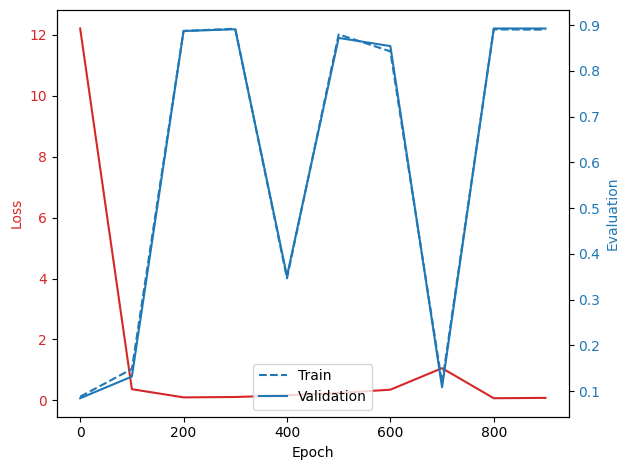

In [22]:
plot_training(iters_list, loss_list, train_eval_list, valid_eval_list)

In [17]:
eval_acc = get_accuracy(net_eq, valid)
eval_mse = get_mse(net_eq, valid)
print(eval_acc)
print(eval_mse)

0.8351515151515152
0.689967930316925


In [18]:
net = Net(train.tensors[0].shape[1], 100, 1)
state_dict = torch.load("starting_model.tar")
net.load_state_dict(state_dict)

data_expensive = data_proc.loc[data_proc["SalePrice"] == 2]
_, valid_expensive = train_valid_split(data_expensive)
valid_expensive = data_to_dataset(data_expensive, target="SalePrice")

eval_acc_2 = get_accuracy(net_eq, valid_expensive)
print("Model with equalized classes")
print(eval_acc_2)
eval_acc = get_accuracy(net, valid_expensive)
print("Model without equalized classes")
print(eval_acc)

Model with equalized classes
0.9070175438596492
Model without equalized classes
0.5456140350877193


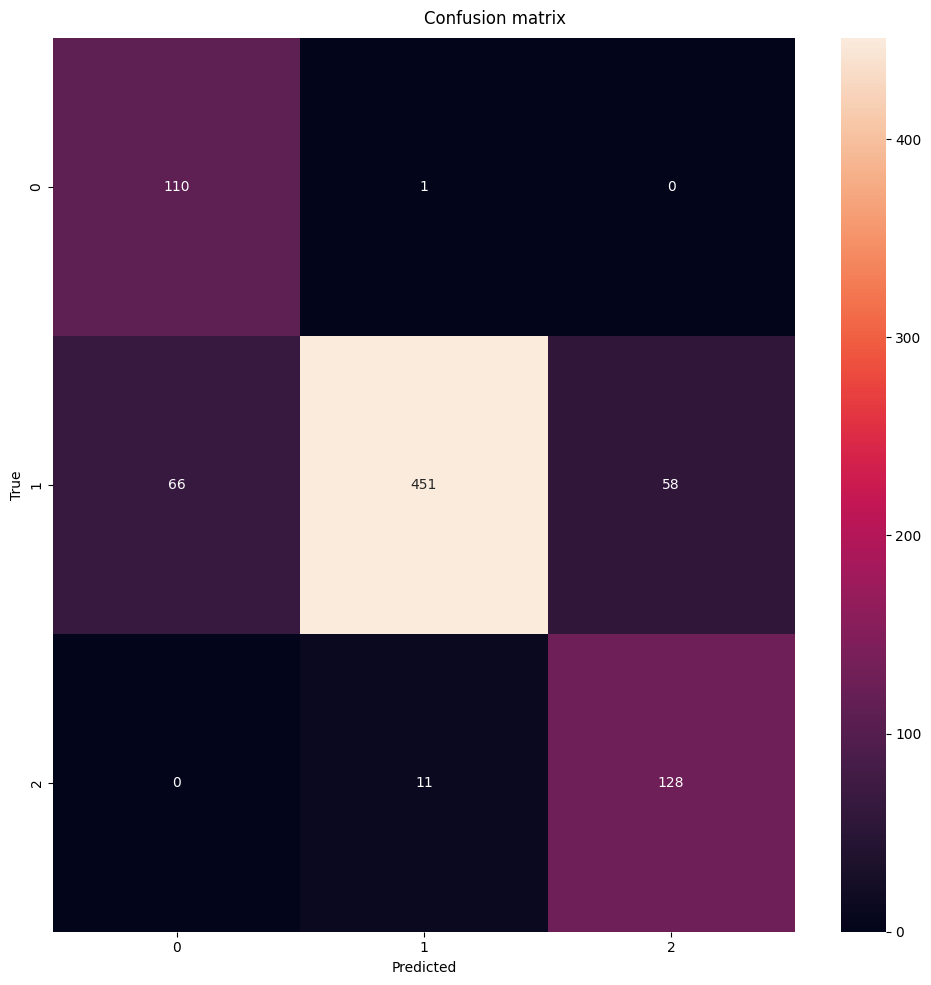

In [19]:
get_confusion_matrix(net_eq, valid)

In [25]:
torch.save(net_eq.state_dict(), "equalized_model.tar")

## Struktury modeli

### Struktury warstw

In [34]:
from models import NetLayers

In [35]:
layer_values = [25, 50, 100] 
num_layers = [2, 3, 5]

In [36]:
res = pd.DataFrame(columns=["layer", "num_layers", "accuracy", "overfitting"])
training = {}

for layer in layer_values:
    for num_layer in num_layers:
        net = NetLayers(train_eq.tensors[0].shape[1], hidden_size=layer, num_layers=num_layer, output_size=1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(net.parameters(), lr=0.001)
        iters_list, loss_list, train_eval_list, valid_eval_list = train_model(net, train_eq, valid_eq, criterion, optimizer, get_accuracy, num_epochs=1000)
        training[(layer, num_layer)] = (iters_list, loss_list, train_eval_list, valid_eval_list)
        eval_acc = get_accuracy(net, valid)
        overfitting = get_overfitting(net, train_eq, valid_eq, get_accuracy)
        res = pd.concat([res, pd.DataFrame([[layer, num_layer, eval_acc, overfitting]], columns=res.columns)])

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:36<00:00, 10.38it/s]
/tmp/ipykernel_40622/2311077484.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, pd.DataFrame([[layer, num_layer, eval_acc, overfitting]], columns=res.columns)])
100%|██████████| 1000/1000 [01:36<00:00, 10.39it/s]


In [37]:
res = pd.read_csv("res_layer.csv", sep=";")

In [38]:
display(res.sort_values("accuracy", ascending=False))

,layer,num_layers,accuracy,overfitting
0,25,5,0.840000,0.003079
1,25,3,0.836364,-0.005556
2,50,3,0.835152,0.003914
3,100,5,0.833939,0.000432
4,100,2,0.832727,0.004331
5,50,5,0.827879,0.001964
6,100,3,0.826667,0.001686
7,25,2,0.825455,0.001825
8,50,2,0.820606,-0.000682


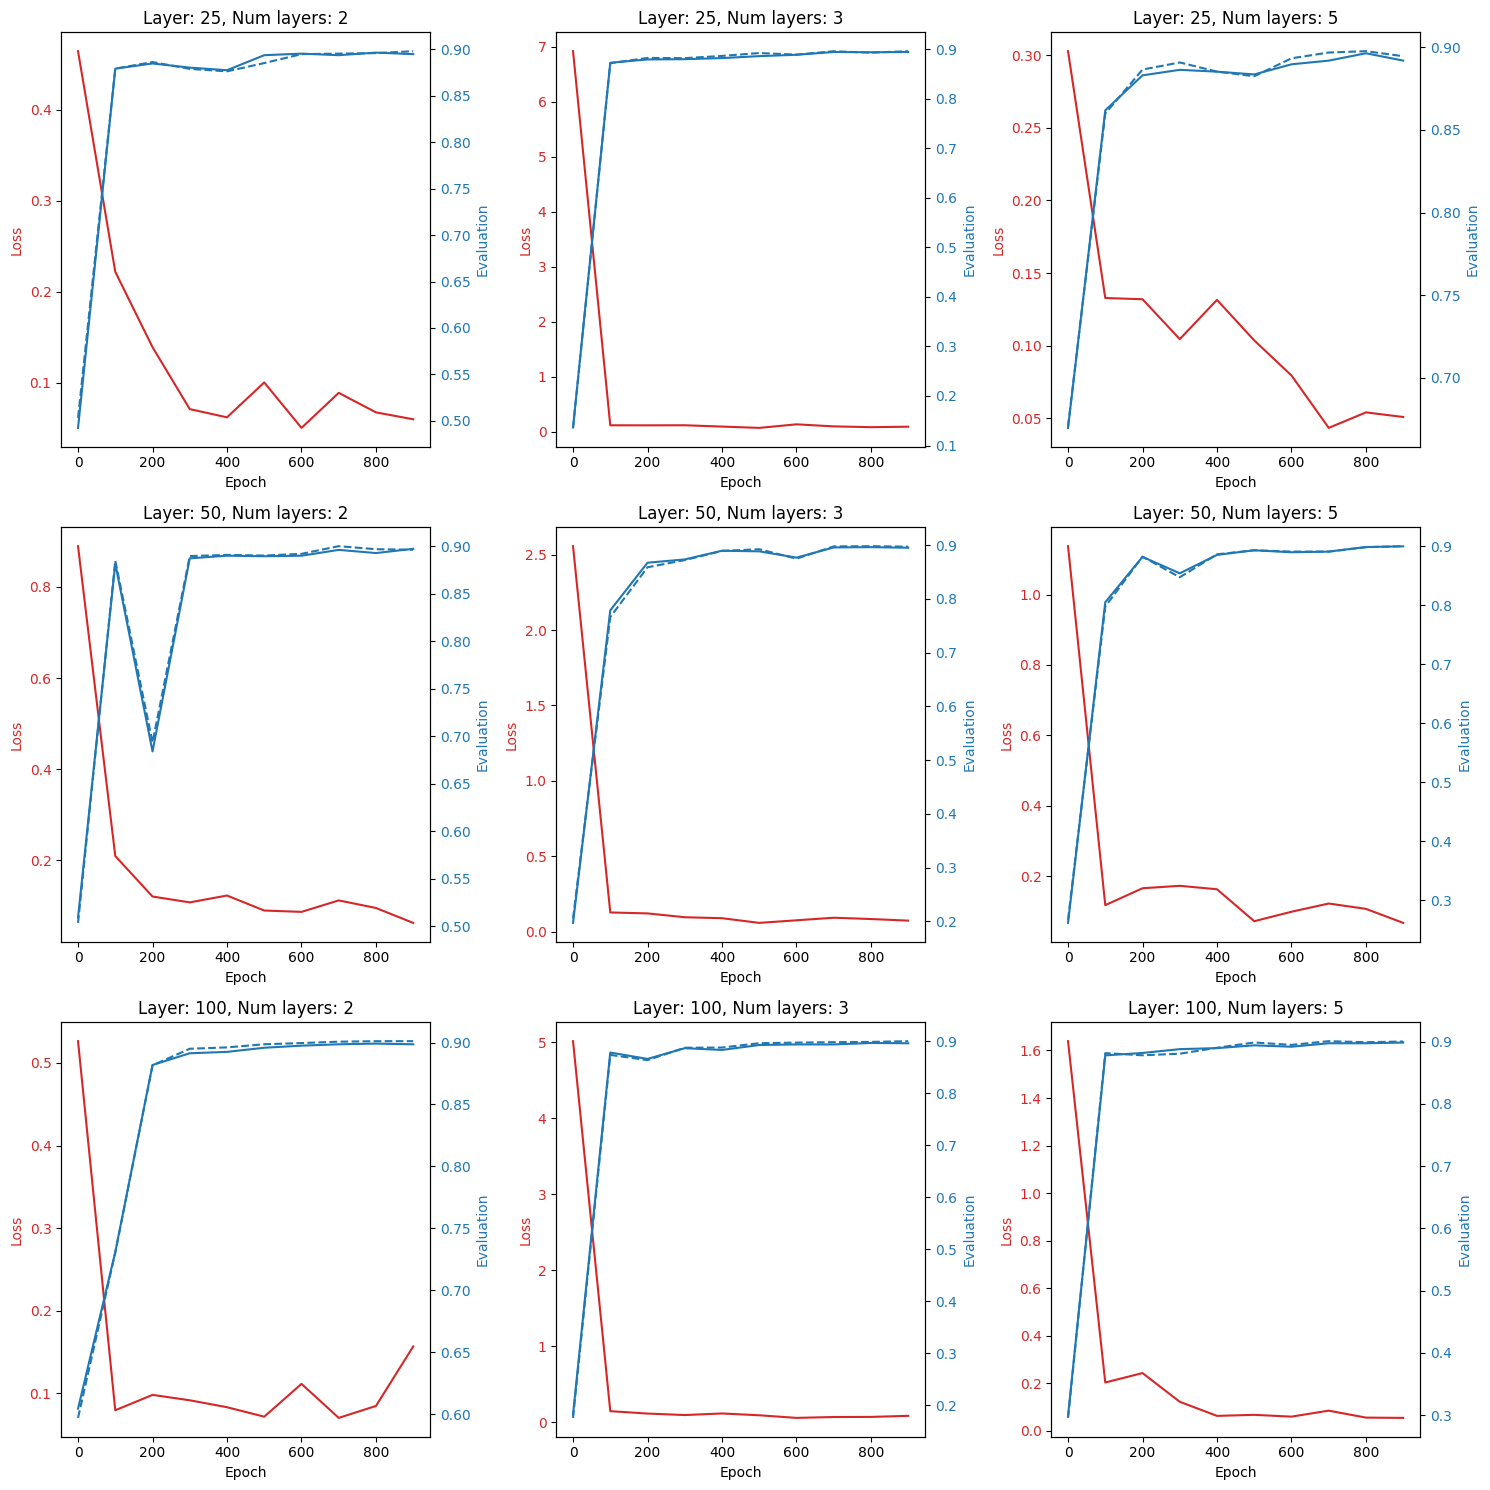

In [38]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, layer in enumerate(layer_values):
    for j, num_layer in enumerate(num_layers):
        iters_list, loss_list, train_eval_list, valid_eval_list = training[(layer, num_layer)]
        plot_training(iters_list, loss_list, train_eval_list, valid_eval_list, ax=axs[i, j])
        axs[i, j].set_title(f"Layer: {layer}, Num layers: {num_layer}")
plt.tight_layout()
plt.show()

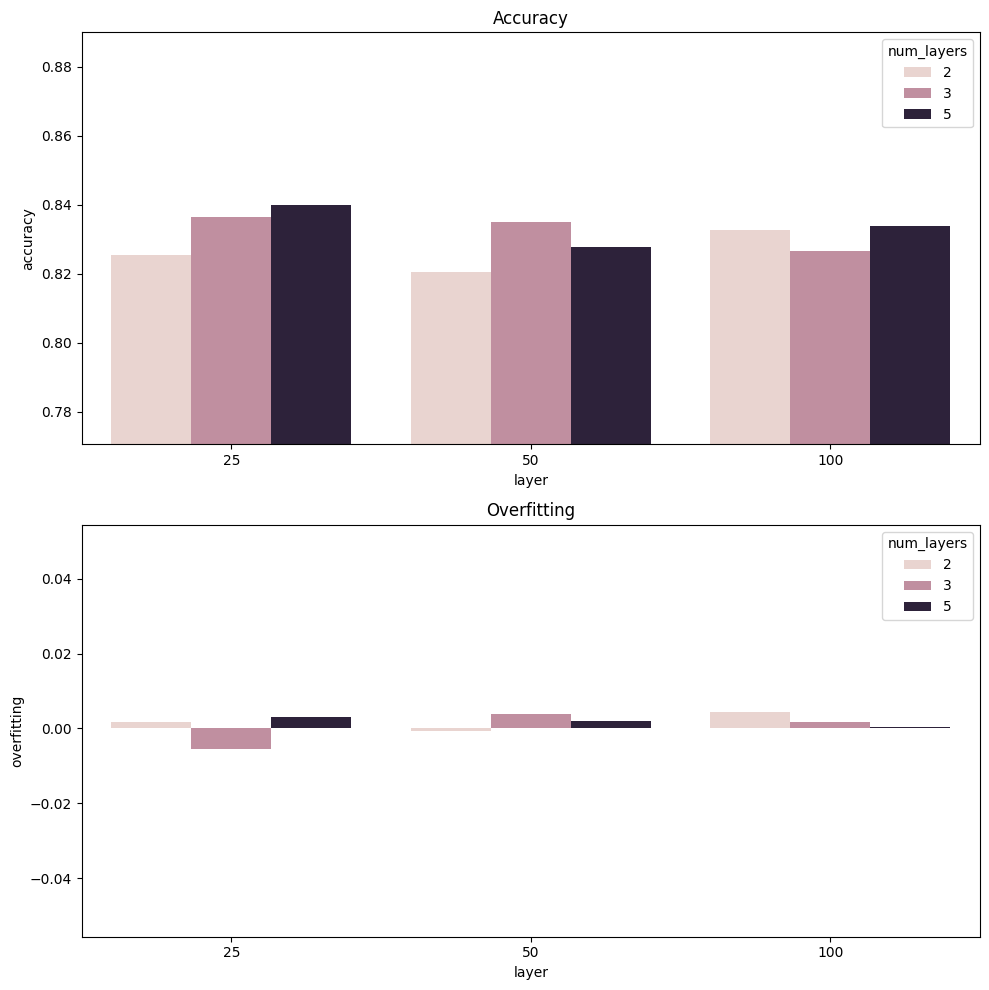

In [39]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(data=res, x="layer", y="accuracy", hue="num_layers", ax=axs[0])
axs[0].set_title("Accuracy")
axs[0].set_ylim(min(res["accuracy"]) - 0.05, max(res["accuracy"]) + 0.05)
sns.barplot(data=res, x="layer", y="overfitting", hue="num_layers", ax=axs[1])
axs[1].set_title("Overfitting")
axs[1].set_ylim(min(res["overfitting"]) - 0.05, max(res["overfitting"]) + 0.05)
plt.tight_layout()
plt.show()

In [12]:
epoch_nums = [1000, 2000, 5000]

In [13]:
res_epochs = pd.DataFrame(columns=["epochs", "accuracy", "overfitting"])
training_epochs = {}

for epoch_num in epoch_nums:
    net = NetLayers(train_eq.tensors[0].shape[1], hidden_size=100, num_layers=5, output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    iters_list, loss_list, train_eval_list, valid_eval_list = train_model(net, train_eq, valid_eq, criterion, optimizer, get_accuracy, num_epochs=epoch_num)
    training_epochs[epoch_num] = (iters_list, loss_list, train_eval_list, valid_eval_list)
    eval_acc = get_accuracy(net, valid)
    overfitting = get_overfitting(net, train_eq, valid_eq, get_accuracy)
    res_epochs = pd.concat([res_epochs, pd.DataFrame([[epoch_num, eval_acc, overfitting]], columns=res_epochs.columns)])

100%|██████████| 1000/1000 [01:40<00:00,  9.92it/s]
/tmp/ipykernel_71965/1672688973.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_epochs = pd.concat([res_epochs, pd.DataFrame([[epoch_num, eval_acc, overfitting]], columns=res_epochs.columns)])
100%|██████████| 5000/5000 [08:01<00:00, 10.38it/s]


In [14]:
display(res_epochs.sort_values("accuracy", ascending=False))

,epochs,accuracy,overfitting
0,1000,0.833939,-0.001518
0,2000,0.832727,0.003077
0,5000,0.824242,-0.000683


In [16]:
res_epochs.to_csv("res_epochs.csv", sep=";")

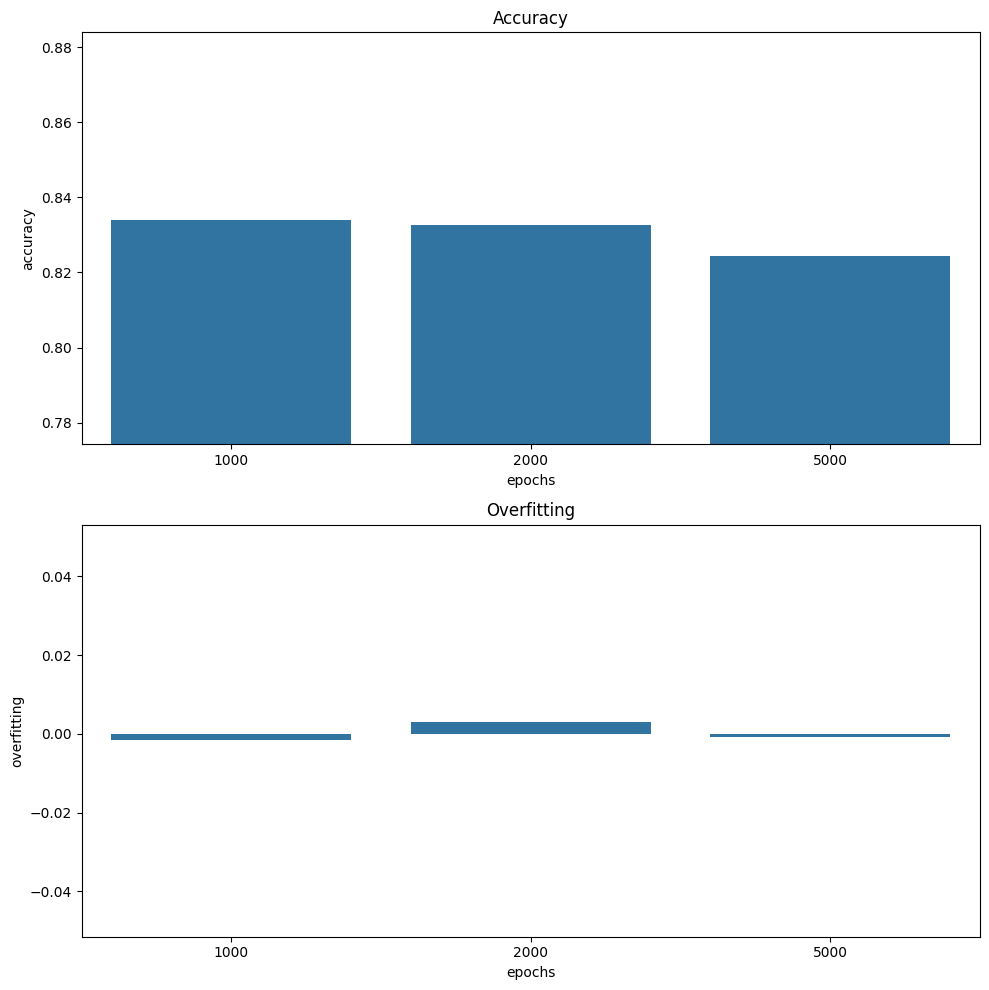

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
sns.barplot(data=res_epochs, x="epochs", y="accuracy", ax=axs[0])
axs[0].set_title("Accuracy")
axs[0].set_ylim(min(res_epochs["accuracy"]) - 0.05, max(res_epochs["accuracy"]) + 0.05)
sns.barplot(data=res_epochs, x="epochs", y="overfitting", ax=axs[1])
axs[1].set_title("Overfitting")
axs[1].set_ylim(min(res_epochs["overfitting"]) - 0.05, max(res_epochs["overfitting"]) + 0.05)
plt.tight_layout()

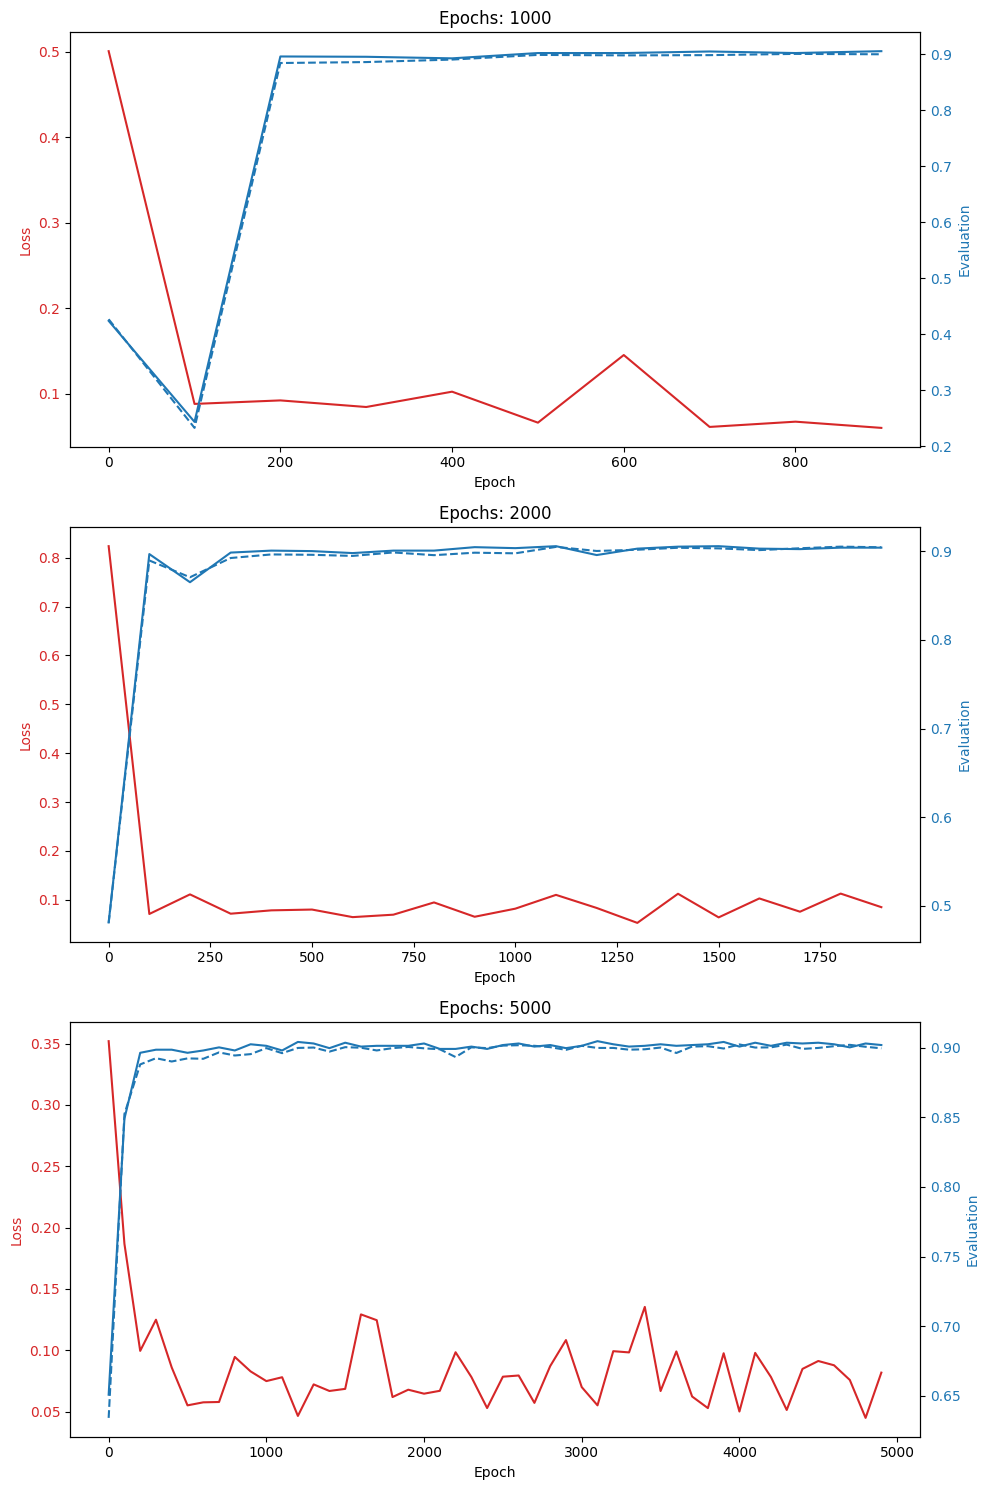

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
for i, epoch_num in enumerate(epoch_nums):
    iters_list, loss_list, train_eval_list, valid_eval_list = training_epochs[epoch_num]
    plot_training(iters_list, loss_list, train_eval_list, valid_eval_list, ax=axs[i])
    axs[i].set_title(f"Epochs: {epoch_num}")
plt.tight_layout()
plt.show()

### Batch norm

In [20]:
from models import NetBatchNorm

batch_norm_net = NetBatchNorm(train.tensors[0].shape[1], 100, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(batch_norm_net.parameters(), lr=0.001)

In [21]:
train_bn = False
if train_bn:
    iters_list, loss_list, train_eval_list, valid_eval_list = train_model(batch_norm_net, train_eq, valid_eq, criterion, optimizer, get_accuracy, num_epochs=2000)
else:
    state_dict = torch.load("batch_norm_model.tar")
    batch_norm_net.load_state_dict(state_dict)

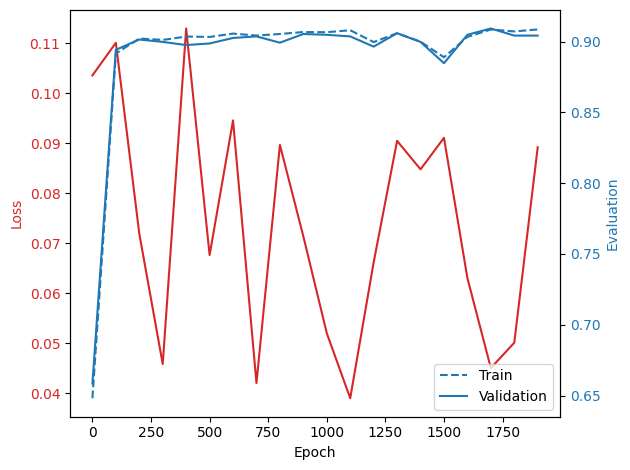

In [34]:
plot_training(iters_list, loss_list, train_eval_list, valid_eval_list)

In [22]:
final_acc = get_accuracy(batch_norm_net, valid)
final_mse = get_mse(batch_norm_net, valid)
print(final_acc)
print(final_mse)

0.8351515151515152
0.6563236117362976


In [23]:
final_acc_expensive = get_accuracy(batch_norm_net, valid_expensive)
final_mse_expensive = get_mse(batch_norm_net, valid_expensive)
print("Model accuracy on expensive houses:")
print(final_acc_expensive)
print("Model MSE on expensive houses:")
print(final_mse_expensive)

Model accuracy on expensive houses:
0.956140350877193
Model MSE on expensive houses:
0.043384961783885956


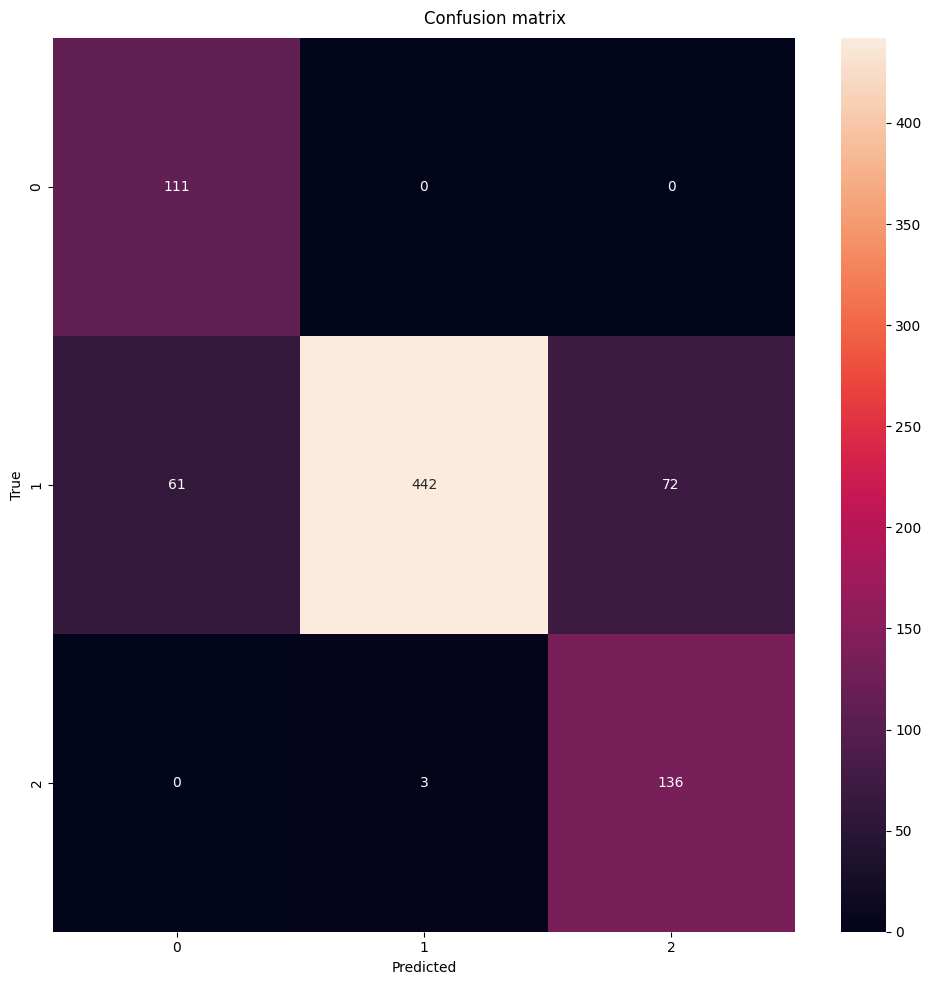

In [24]:
get_confusion_matrix(batch_norm_net, valid)

In [37]:
torch.save(batch_norm_net.state_dict(), "batch_norm_model.tar")

### Dropout

In [38]:
from models import NetDropout

dropout_net = NetDropout(train.tensors[0].shape[1], 100, 1)

In [39]:
iters_list, loss_list, train_eval_list, valid_eval_list = train_model(dropout_net, train_eq, valid_eq, criterion, optimizer, get_accuracy, num_epochs=2000)

100%|██████████| 2000/2000 [03:09<00:00, 10.57it/s]


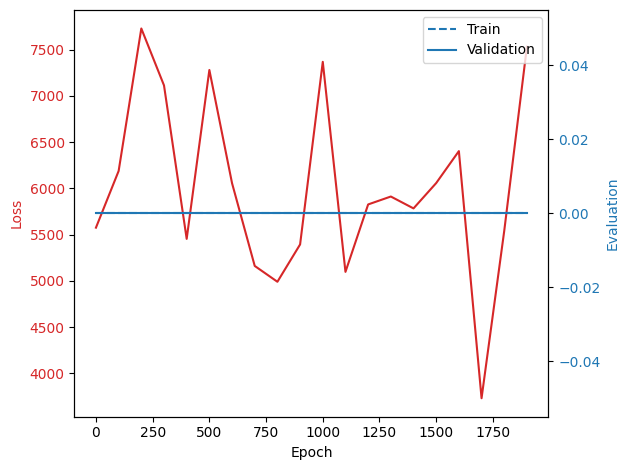

In [40]:
plot_training(iters_list, loss_list, train_eval_list, valid_eval_list)

In [41]:
dropout_03_net = NetDropout(train_eq.tensors[0].shape[1], 100, 1, dropout_p=0.2)

In [43]:
iter_list, loss_list, train_eval_list, valid_eval_list = train_model(dropout_03_net, train_eq, valid_eq, criterion, optimizer, get_accuracy, num_epochs=1000)

100%|██████████| 1000/1000 [01:34<00:00, 10.59it/s]


ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

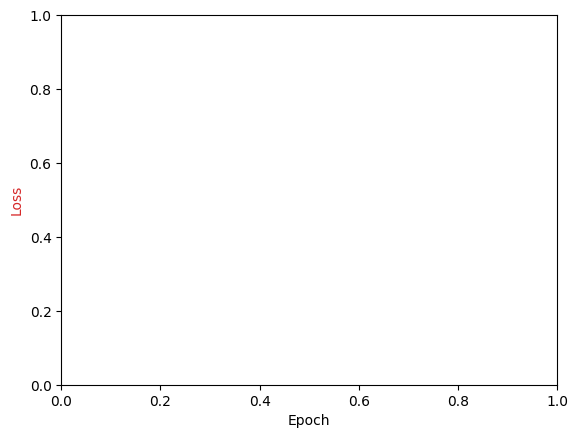

In [47]:
plot_training(iters_list, loss_list, train_eval_list, valid_eval_list)

### Weight decay

In [28]:
net_decay = NetBatchNorm(train_eq.tensors[0].shape[1], 100, 1)
optimizer = optim.Adam(net_decay.parameters(), lr=0.001, weight_decay=0.001)
criterion = nn.MSELoss()

In [29]:
iter_list, loss_list, train_eval_list, valid_eval_list = train_model(net_decay, train_eq, valid_eq, criterion, optimizer, get_accuracy, num_epochs=2000)

100%|██████████| 2000/2000 [03:50<00:00,  8.68it/s]


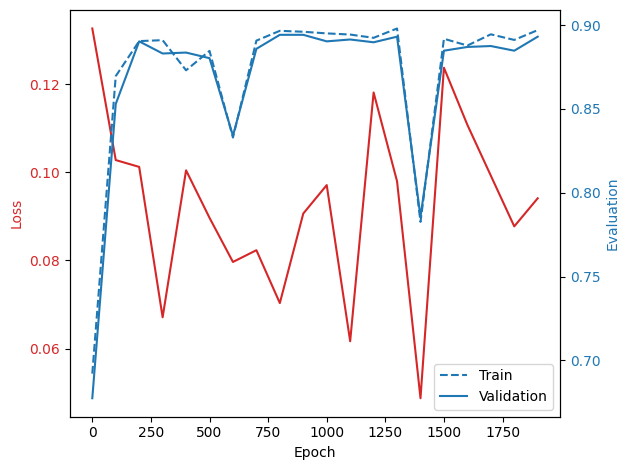

In [30]:
plot_training(iter_list, loss_list, train_eval_list, valid_eval_list)

In [31]:
final_acc = get_accuracy(net_decay, valid)
final_mse = get_mse(net_decay, valid)
print(final_acc)
print(final_mse)

0.8024242424242424
0.6691154837608337


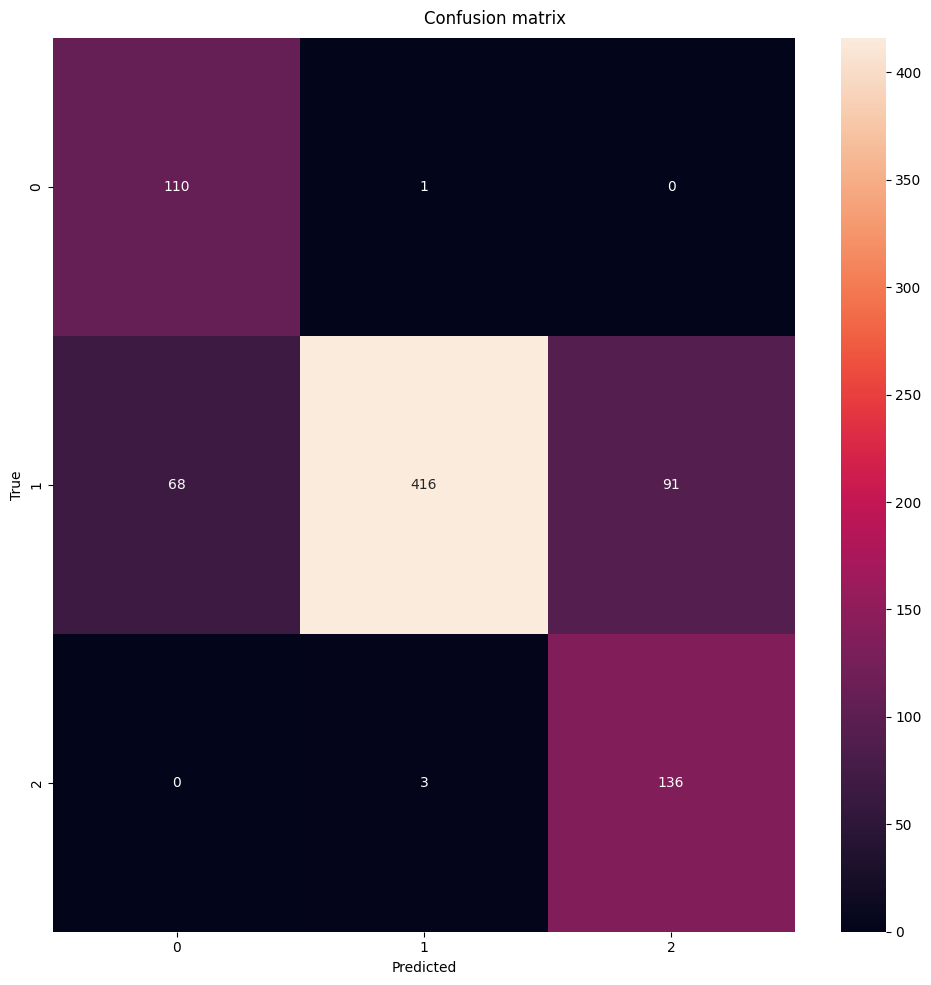

In [32]:
get_confusion_matrix(net_decay, valid)

In [33]:
torch.save(net_decay.state_dict(), "decay_model.tar")

### Wagi klas

In [12]:
weights = [0.3, 1, 0.3]
weights_net = NetBatchNorm(train_eq.tensors[0].shape[1], 100, 3)
class_weights = torch.tensor(weights, dtype=torch.float32).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(weights_net.parameters(), lr=0.001, weight_decay=0.001)

In [15]:
def accuracy_weighted(model, data):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in torch.utils.data.DataLoader(data, batch_size=len(data)):
            x, y = x.cuda(), y.cuda()
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    model.train()
    return correct / total

In [22]:
def train_model_w(model, train, valid, criterion, optimizer, eval_func, batch_size=100, num_epochs=1000, verbose=True, epoch_interval=100, device=torch.device('cuda')):
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

    iters_list = []
    loss_list = []
    train_eval_list = []
    valid_eval_list = []

    _range = range(num_epochs)
    if verbose:
        _range = tqdm(_range)
    for epoch in _range:
        for i, (x, y) in enumerate(train_loader):
            y = y.type(torch.LongTensor)
            x = x.to(device)
            y = y.to(device)
            model.train()
            y_pred = model(x)
            y_pred = y_pred.squeeze()
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % epoch_interval == 0:
            iters_list.append(epoch)
            loss_list.append(loss.item())
            train_eval_list.append(eval_func(model, train))
            valid_eval_list.append(eval_func(model, valid))

    return iters_list, loss_list, train_eval_list, valid_eval_list

In [42]:
iters_list, loss_list, train_eval_list, valid_eval_list = train_model_w(weights_net, train_eq, valid_eq, criterion, optimizer, accuracy_weighted, num_epochs=1000)

100%|██████████| 1000/1000 [01:57<00:00,  8.49it/s]


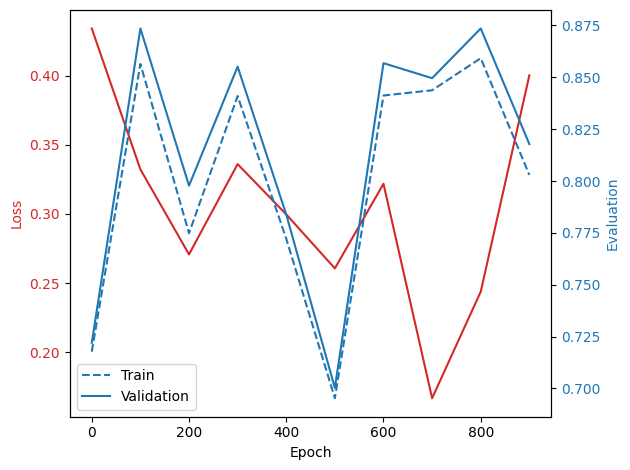

In [43]:
plot_training(iters_list, loss_list, train_eval_list, valid_eval_list)

In [45]:
final_acc = accuracy_weighted(weights_net, valid)
print(final_acc)

0.8763636363636363


In [43]:
def get_confusion_matrix_w(model, data):
    model.eval()
    with torch.no_grad():
        for x, y in torch.utils.data.DataLoader(data, batch_size=len(data)):
            x, y = x.cuda(), y.cuda()
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            confusion = pd.crosstab(y.cpu().numpy(), predicted.cpu().numpy(), rownames=['Actual'], colnames=['Predicted'])
            sns.heatmap(confusion, annot=True, fmt='d')
            plt.show()
    model.train()


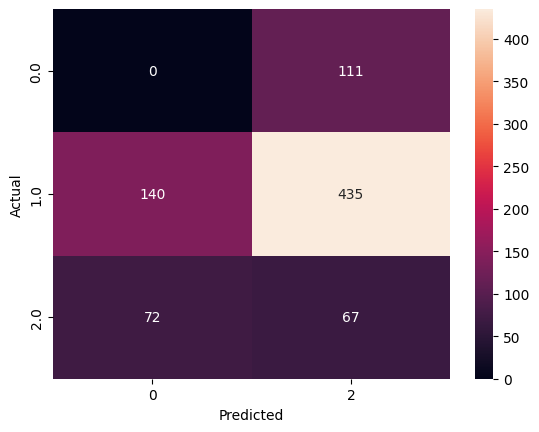

In [44]:
get_confusion_matrix_w(weights_net, valid)

In [46]:
torch.save(weights_net.state_dict(), "weights_model.tar")

### Embeddingi

In [13]:
net_emb = NetEmbedding(vocab_size=train_eq.tensors[0].shape[1], embedding_dim=100, hidden_size=100, output_size=3)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(net_emb.parameters(), lr=0.001, weight_decay=0.001)

In [16]:
iters_list, loss_list, train_eval_list, valid_eval_list = train_model(net_emb, train_eq, valid_eq, criterion, optimizer, accuracy_weighted, num_epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/Indexing.cu:1290: indexSelectLargeIndex: block: [22,0,0], thread: [64,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1290: indexSelectLargeIndex: block: [22,0,0], thread: [65,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1290: indexSelectLargeIndex: block: [22,0,0], thread: [66,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1290: indexSelectLargeIndex: block: [22,0,0], thread: [67,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1290: indexSelectLargeIndex: block: [22,0,0], thread: [68,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1290: indexSelectLargeIndex: block: [22,0,0], thread: [69,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1290: i

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
plot_training(iters_list, loss_list, train_eval_list, valid_eval_list)

In [ ]:
get_confusion_matrix_w(net_emb, valid)

## Finałowy model

In [46]:
class NetFinal(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NetFinal, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu_1 = nn.ReLU()
        self.d1 = torch.nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu_2 = nn.ReLU()
        self.d2 = torch.nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.relu_3 = nn.ReLU()
        self.d3 = torch.nn.Dropout(p=0.3)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.bn4 = nn.BatchNorm1d(hidden_size)
        self.relu_4 = nn.ReLU()
        self.d4 = torch.nn.Dropout(p=0.3)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.relu_5 = nn.ReLU()
        self.out = nn.Linear(hidden_size, output_size)
        self = self.cuda()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu_1(x)
        x = self.d1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu_2(x)
        x = self.d2(x)
        x = self.fc3(x)
        x = self.relu_3(x)
        x = self.d3(x)
        x = self.fc4(x)
        x = self.relu_4(x)
        x = self.d4(x)
        x = self.fc5(x)
        x = self.relu_5(x)
        x = self.out(x)
        return x

In [47]:
weights = [0.25, 1, 0.25]
class_weights = torch.tensor(weights, dtype=torch.float32).cuda()

net_final = NetFinal(train_eq.tensors[0].shape[1], 100, 3)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(net_final.parameters(), lr=0.001, weight_decay=0.001)

In [48]:
iter_list, loss_list, train_eval_list, valid_eval_list = train_model_w(net_final, train_eq, valid_eq, criterion, optimizer, accuracy_weighted, num_epochs=2500)

100%|██████████| 2500/2500 [05:59<00:00,  6.95it/s]


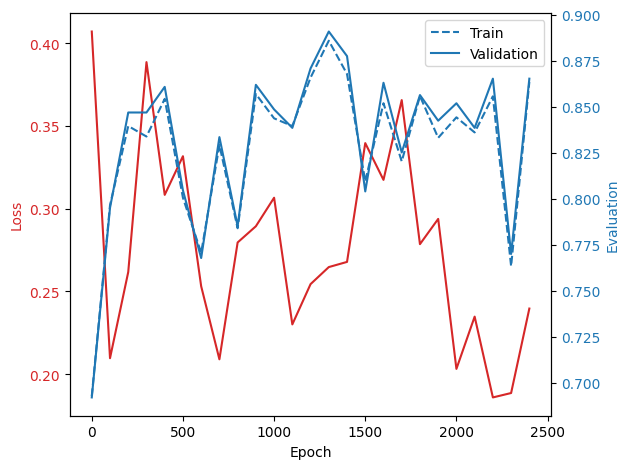

In [49]:
plot_training(iter_list, loss_list, train_eval_list, valid_eval_list)

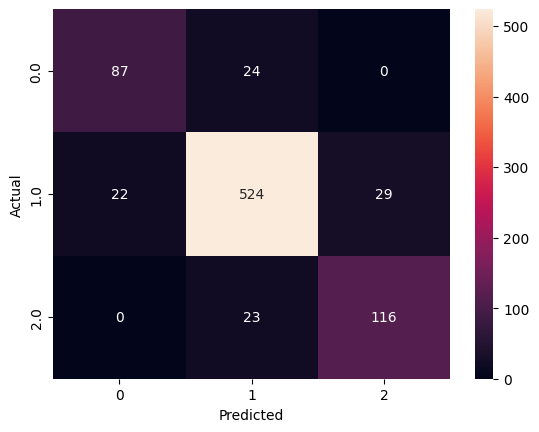

In [50]:
get_confusion_matrix_w(net_final, valid)

In [51]:
final_acc = accuracy_weighted(net_final, valid)
print(final_acc)

0.8812121212121212


In [52]:
torch.save(net_final.state_dict(), "final_model.tar")